In [5]:
# --- Standard libraries
import pickle as pkl
import numpy as np
import heapq as hq
from icecream import ic
# --- PyTorch
import torch
# --- PyG
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
# --- NetworkX
import networkx as nx
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
# --- Modules from local files
from GNN_atom import GNN
from Dataset import XASDataset
from train import train_atom
from test import test_atom
from utils import plot_learning_curve
rdkit.__version__

'2023.09.5'

#### Define functions to be used

In [2]:
def pred_spec(model, index, test_dataset):
    # --- Set the model to evaluation mode
    model.eval()

    # --- Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])
    #print(batch.atom_num)


    # --- Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)
    
    # ---  the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.spectrum.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum, true_spectrum

#### Load dataset

In [6]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset(path)

In [7]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[31]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(7946)
------------
Number of graphs: 7946
Number of features: 18
Number of classes: 0

Data(x=[28, 18], edge_index=[2, 72], edge_attr=[72, 6], spectrum=[200], vector=[18], idx=[1], smiles='C123[C:2]4=[CH:1][CH2:23][C:22]5=[CH:21][CH2:19][C:18]67[C:16]([c:12]8[c:8]9[c:10]([cH:11][cH:13][c:14]8[CH:15]=[CH:17]6)=[CH:9][C:7](=[O:24])[C:6]([OH:27])([C:4]=91)[CH:5]=[CH:3]4)([C:20]25[O:26]3)[O:25]7', atom_num=[1], neighbors=[2])
------------
Number of nodes: 28
Number of edges: 72
Average node degree: 2.57
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [8]:
torch.save(dataset, './XASNet-data/atom_dataset.pt')

#### View data

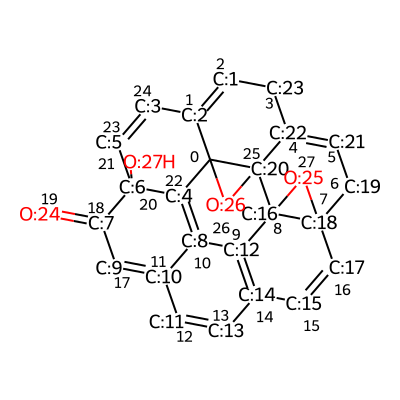

In [9]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

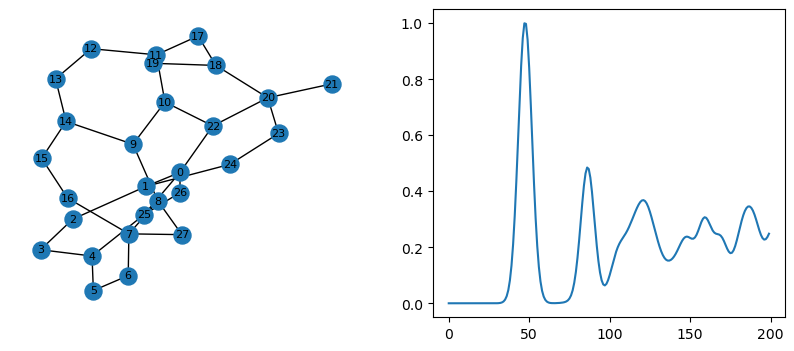

In [10]:
# --- Create subplot for 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show an atomic spectrum from molecule
ax2.plot(data.spectrum)
plt.show()

#### Split up dataset

In [22]:
# --- Split into test, validation and test
train_dataset = dataset[0:100]
val_dataset = dataset[5958:6000]
test_dataset = dataset[7151:7946]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=42, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datasets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

Length of training data loader: 100, with a total of 1 datasets
Length of validation data loader: 42, with a total of 1 datasets
Length of testing data loader: 795, with a total of 13 datasets


In [9]:
torch.save(test_dataset, './processed/atom_test_dataset.pt')

In [23]:
print(train_loader.dataset[0])
print(train_loader.dataset[0].vector)
print(train_loader.dataset[0].atom_num)
print(train_loader.dataset[0].neighbors)

Data(x=[29, 18], edge_index=[2, 72], edge_attr=[72, 6], spectrum=[200], vector=[18], idx=[1], smiles='c12[c:4]3[c:8]4[c:10]5[cH:11][c:13]([OH:26])[c:14]6[c:12]4[c:16]4[c:18]([cH:17][cH:15]6)=[CH:19][C:21](=[O:27])[CH:22]([c:20]14)[CH:23]1[CH:1]([C:2]2=[CH:3][C:5](=[O:24])[CH:6]3[CH:7]=[C:9]5[OH:25])[O:28]1', atom_num=[1], neighbors=[3])
tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.5781,
        0.4219, 0.0000, 0.0000, 0.5781, 0.4219, 0.5781, 0.5781, 0.4219, 0.0000])
tensor([1])
[0, 2, 24]


#### Set neural network properties

In [24]:
num_tasks = 200
num_layers = 4
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 512, 256, 128]
out_channels = [512, 256, 128, 64]
gnn_type = 'gcn'
heads = int(1)
drop_ratio = 0.25
graph_pooling = 'mean'

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(18, 512)
      (1): GCNConv(512, 256)
      (2): GCNConv(256, 128)
      (3): GCNConv(128, 64)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=64, out_features=200, bias=True)
)
----
Training will be performed on: cpu


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [27]:
num_epochs = 500
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    loss, a,b,c,d, out, true = train_atom(epoch, train_loader, model, device, optimizer)
    #loss, a,b,c,d = train(epoch)
    
    # plt.plot(out)
    # plt.plot(true)
    # plt.ylim(-0.2, 1.2)
    # plt.xlim(0, 200)
    # plt.title(f'epoch: {epoch}')
    # plt.savefig(f'./images/training/graph_{epoch}.png')
    # plt.close()
    
    val_error = test_atom(val_loader, model, device)
    #val_error = test(val_loader)

    scheduler.step(val_error)
    #scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)
    
    current_lr = optimizer.param_groups[0]['lr']

    if best_val_error is None or val_error <= best_val_error:
        
        best_val_error = val_error
    if epoch%25 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss: {val_error:7f}, Best_ValLoss: {best_val_error:7f}')


Epoch: 000, LR: 0.010000, TrainLoss: 0.6776382, ValLoss: 0.103754, Best_ValLoss: 0.103754
Epoch: 025, LR: 0.010000, TrainLoss: 0.0490102, ValLoss: 0.047268, Best_ValLoss: 0.047268
Epoch: 050, LR: 0.010000, TrainLoss: 0.0407450, ValLoss: 0.039431, Best_ValLoss: 0.039431
Epoch: 075, LR: 0.010000, TrainLoss: 0.0373941, ValLoss: 0.037670, Best_ValLoss: 0.037670
Epoch: 100, LR: 0.010000, TrainLoss: 0.0364228, ValLoss: 0.038086, Best_ValLoss: 0.037378
Epoch: 125, LR: 0.010000, TrainLoss: 0.0339359, ValLoss: 0.038751, Best_ValLoss: 0.037378
Epoch: 150, LR: 0.010000, TrainLoss: 0.0307130, ValLoss: 0.040430, Best_ValLoss: 0.037378
Epoch: 175, LR: 0.010000, TrainLoss: 0.0294249, ValLoss: 0.041153, Best_ValLoss: 0.037378
Epoch: 200, LR: 0.005000, TrainLoss: 0.0278759, ValLoss: 0.042030, Best_ValLoss: 0.037378
Epoch: 225, LR: 0.005000, TrainLoss: 0.0262129, ValLoss: 0.043994, Best_ValLoss: 0.037378
Epoch: 250, LR: 0.005000, TrainLoss: 0.0240747, ValLoss: 0.046245, Best_ValLoss: 0.037378
Epoch: 275

In [14]:
frames = []

for t in range(num_epochs):
    image = imageio.v2.imread(f'./images/training/graph_{t}.png')
    frames.append(image)

imageio.mimsave('./example.gif', frames, fps=8)

In [15]:
model_name = 'model_gnn_atom_test.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

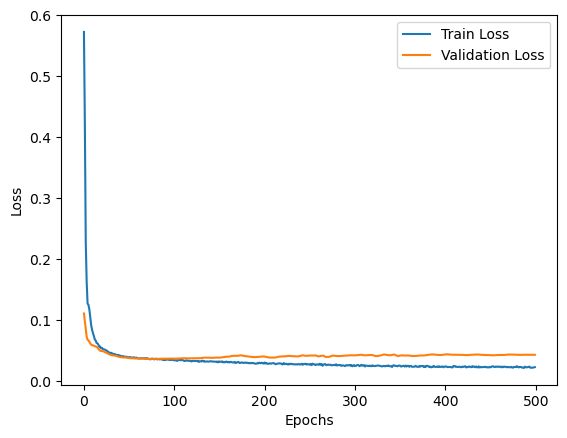

In [20]:
plot_learning_curve(num_epochs, train_losses, val_losses)